In [ ]:
%pip install strands-agents strands-agents-tools mcp mcp[cli]

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

# Strands Agents Python SDK - SageMaker AI Endpoint as Custom Tool

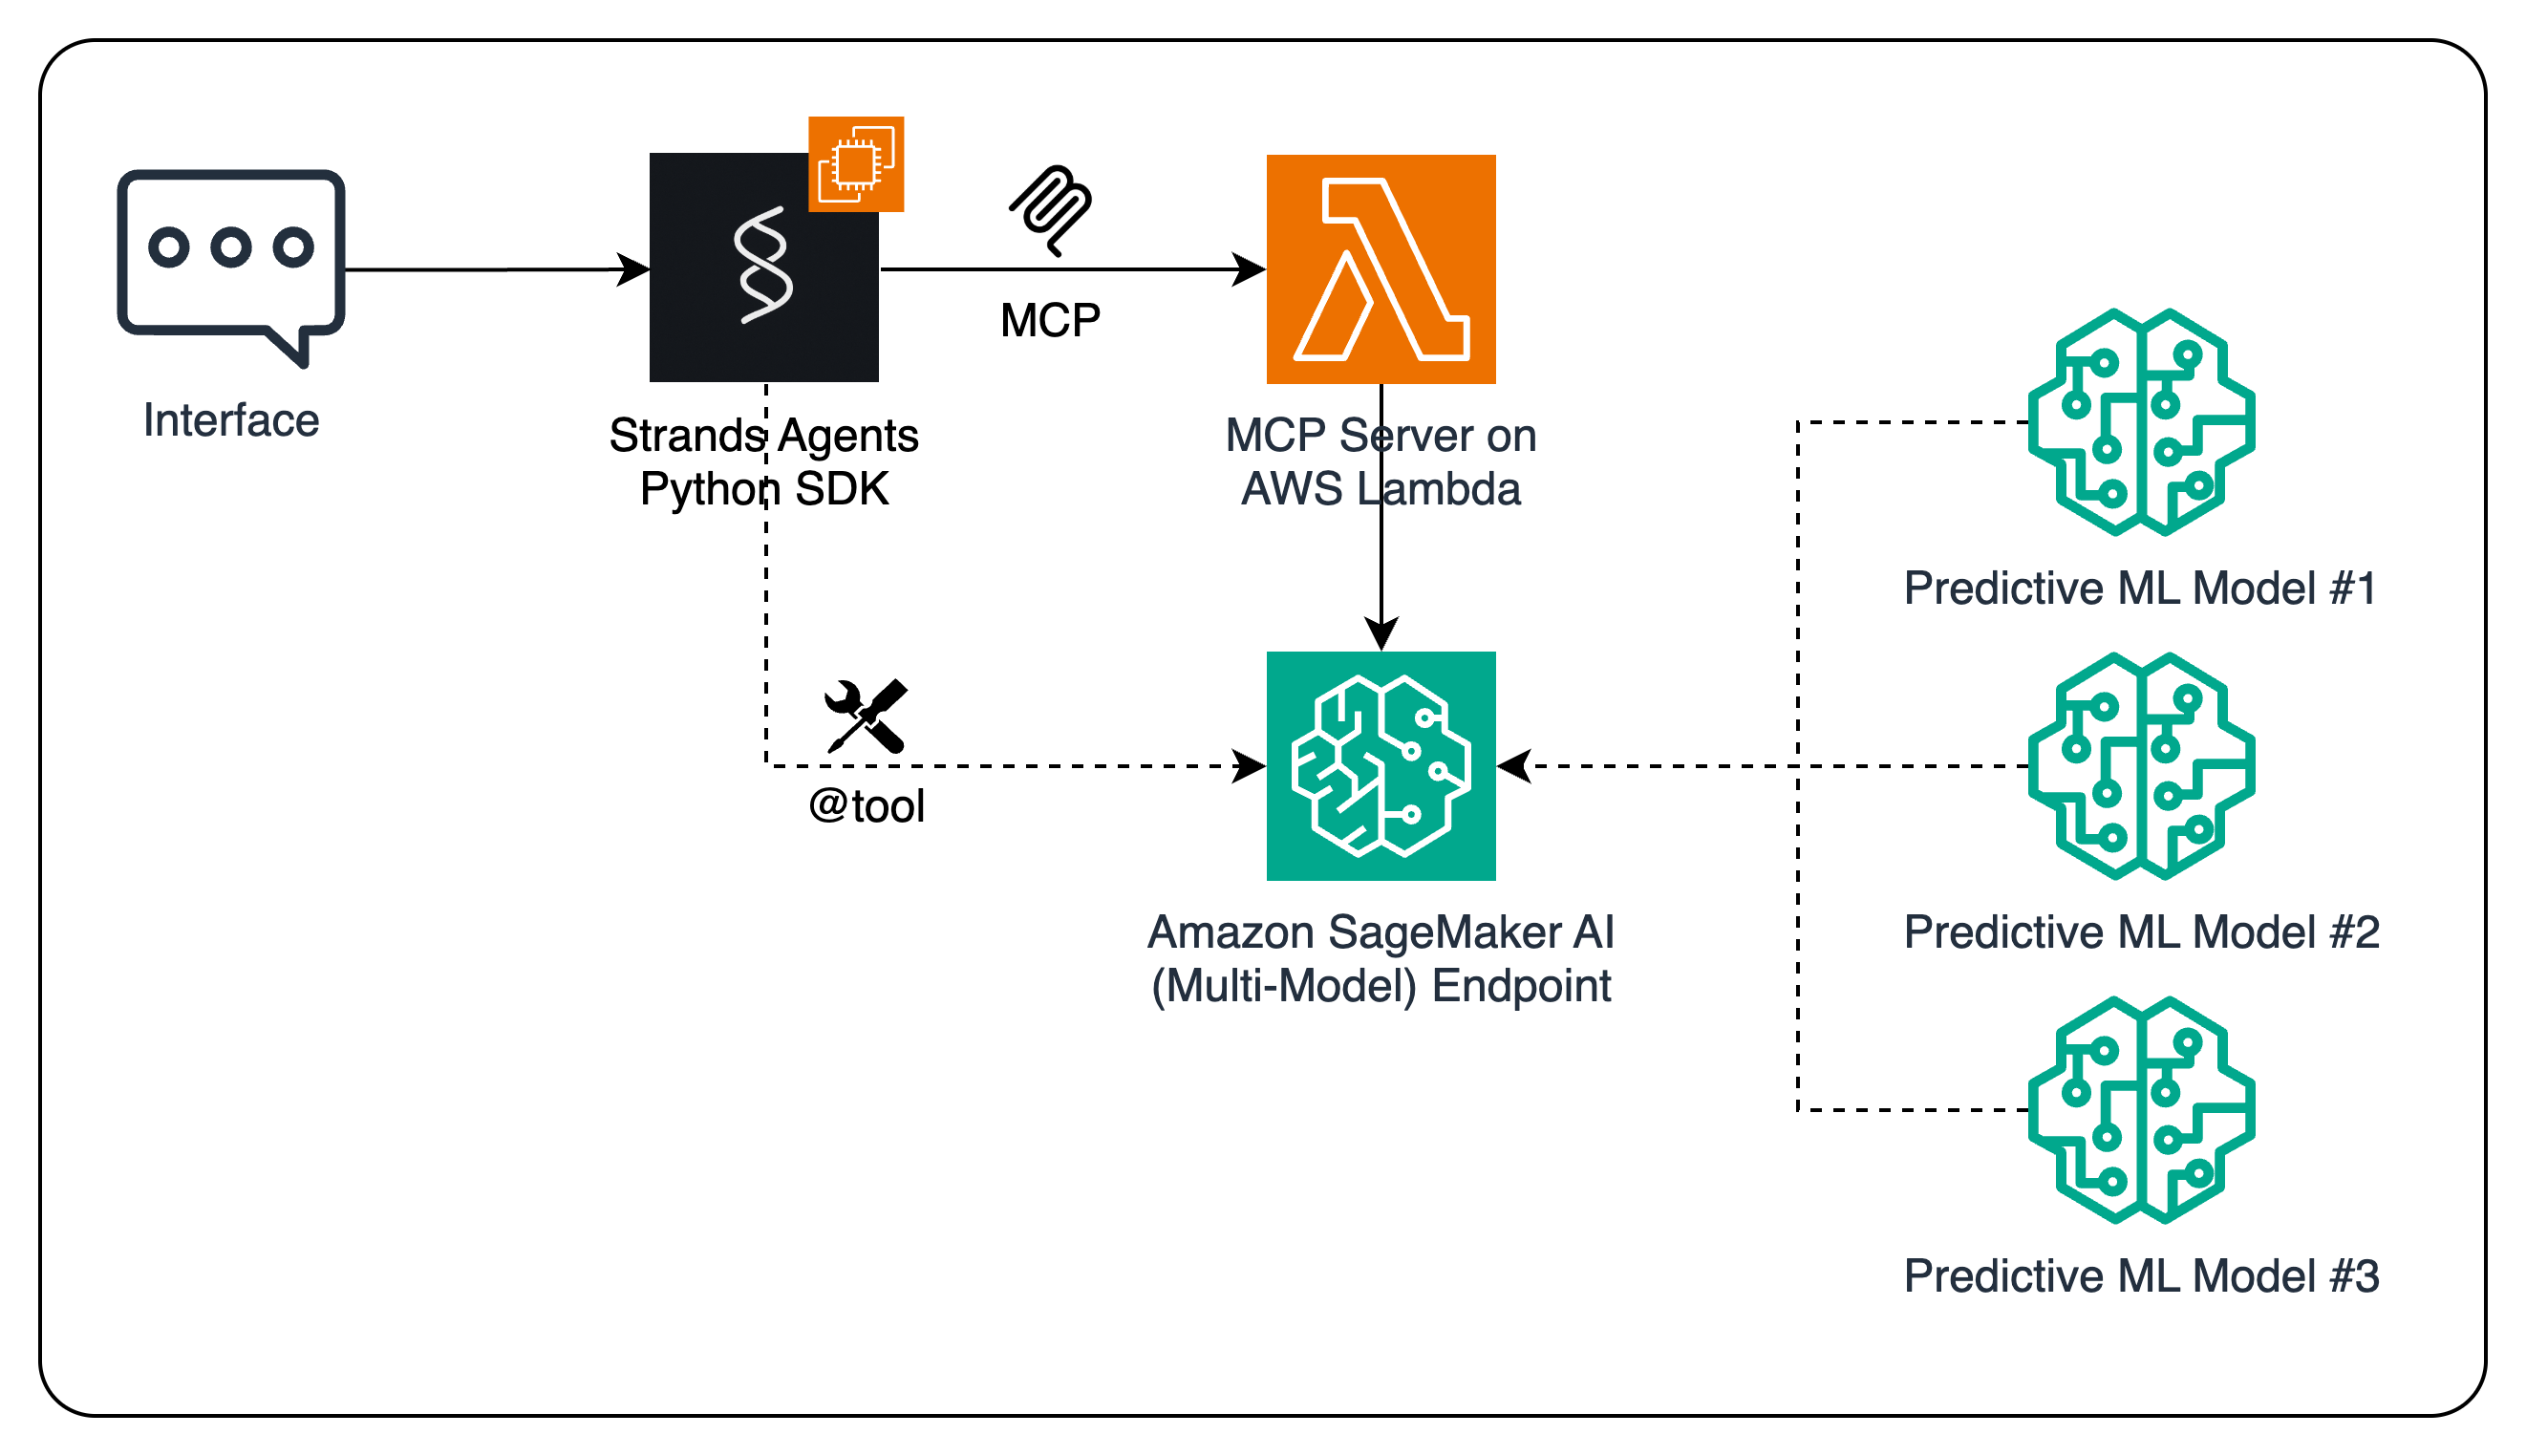

In [ ]:
test_sample = [[6.0,
  9.0,
  18.0,
  2022.0,
  3.0,
  82.32242989519233,
  145.7780143415423,
  119.72411707626237,
  109.00943866750897,
  78.1850279953027,
  27.17729231087614,
  98.725083103897,
  32.3663008574393,
  114.30045179438677,
  31.154757059649896],
 [0.0,
  9.0,
  19.0,
  2022.0,
  3.0,
  112.29372828348961,
  92.05548651574294,
  149.53457153115409,
  72.54645882732314,
  78.59649696115221,
  27.4428007288024,
  94.82516865714953,
  28.874170960965433,
  115.04676214269898,
  30.378550374126004],
 [1.0,
  9.0,
  20.0,
  2022.0,
  3.0,
  94.93576927668948,
  97.7187873924136,
  106.5675777935643,
  133.46975024736352,
  77.82557137676875,
  26.886240262965835,
  93.80764940773277,
  28.67887997302126,
  113.67518074451117,
  30.4468958883678],
 [2.0,
  9.0,
  21.0,
  2022.0,
  3.0,
  92.32230830172934,
  34.350356241745,
  112.97609292100049,
  99.21268633211206,
  80.06729855054992,
  23.0356600622431,
  89.31238894610509,
  30.32804828287802,
  112.03617274871455,
  32.50610622726534],
 [3.0,
  9.0,
  22.0,
  2022.0,
  3.0,
  50.04244645821317,
  77.85694616139921,
  81.35399000575227,
  125.84635801167887,
  82.91003059614825,
  23.927978474812306,
  90.48396612287904,
  30.31376940936954,
  111.09982983101149,
  32.49915610665346]]

In [ ]:
from strands import Agent, tool
import boto3, json
import numpy as np

ENDPOINT_NAME = "ml-models-as-tools"
REGION = boto3.Session().region_name

@tool()
def generate_prediction_with_sagemaker(test_sample: list):
 """
  Use Amazon SageMaker AI to generate predictions.
  Args:
test_sample: a list of lists containing the inputs to generate predictions from
  Returns:
predictions: an array of predictions
 """ 
 sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=REGION)
 response = sagemaker_runtime.invoke_endpoint(
  EndpointName=ENDPOINT_NAME,
  Body=json.dumps(test_sample),
  ContentType="application/json",
  Accept="application/json"
 )
 predictions = json.loads(response['Body'].read().decode("utf-8"))
 return np.array(predictions)


agent = Agent(model="us.amazon.nova-pro-v1:0", tools=[generate_prediction_with_sagemaker])
agent(
 "Invoke the endpoint with this input:\n"
 f"<input>{test_sample}</input>\n\n"
 "Provide the output in JSON format {'predictions':<predictions>}"
)

# Strands Agents Python SDK - SageMaker AI Endpoint via MCP Server (`stdio`)

In [ ]:
from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client


# Create server parameters for stdio connection
server_params = StdioServerParameters(
 command="python3",  # Executable
 args=["server.py"],  # Optional command line arguments
 env={
  "AWS_ACCESS_KEY_ID": boto3.Session().get_credentials().access_key, # Required in Amazon SageMaker AI if using stdio as transport
  "AWS_SECRET_ACCESS_KEY": boto3.Session().get_credentials().secret_key, # Required in Amazon SageMaker AI if using stdio as transport
  "AWS_SESSION_TOKEN": boto3.Session().get_credentials().token, # Required in Amazon SageMaker AI if using stdio as transport
  "AWS_REGION_NAME": REGION,
  "SAGEMAKER_ENDPOINT_NAME": ENDPOINT_NAME
 }
)

In [ ]:
from strands.tools.mcp import MCPClient

stdio_mcp_client = MCPClient(lambda: stdio_client(server_params))

# Create an agent with MCP tools
with stdio_mcp_client:
 # Get the tools from the MCP server
 tools = stdio_mcp_client.list_tools_sync()

 # Create an agent with these tools
 agent = Agent(model="us.amazon.nova-pro-v1:0", tools=tools)

 # Invoke the agent
 agent(
  "Invoke the endpoint with this input:\n\n"
  f"<input>{test_sample}</input>\n\n"
  "Provide the output in JSON format {'predictions':<predictions>}"
 )

## (Optional) Clean up the endpoint

In [ ]:
import boto3
sagemaker = boto3.client("sagemaker", region_name=REGION)
response = sagemaker.delete_endpoint(EndpointName=ENDPOINT_NAME)
print(response)